In [1]:
# import packages
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np
import datetime
import functions_hiwi as fct
import warnings

In [2]:
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
main_dir = r'C:\Users\illic\Python\data_hiwi'

In [4]:
# set paths to specific data
WS100_rtu_path = os.path.join(main_dir, r'WS100_ready_to_use.csv')
WS300_rtu_path = os.path.join(main_dir, r'WS300_ready_to_use.csv')
Raine_rtu_path = os.path.join(main_dir, r'Raine_ready_to_use.csv')
L_pcp_rtu_path = os.path.join(main_dir, r'L_pcp_ready_to_use.csv')
lhg_rtu_path = os.path.join(main_dir, r'lhg_rtu.csv')

In [5]:
# read data

# read data and convert to utc
WS100_rtu = pd.read_csv(WS100_rtu_path, sep=',', index_col=0) # , skiprows=1
WS100_rtu.index = pd.to_datetime(WS100_rtu.index, format='%Y-%m-%d %H:%M:%S') # - pd.DateOffset(hours=1)

WS300_rtu = pd.read_csv(WS300_rtu_path, sep=',', index_col=0) # , skiprows=1
WS300_rtu.index = pd.to_datetime(WS300_rtu.index, format='%Y-%m-%d %H:%M:%S') # - pd.DateOffset(hours=1)

Raine_rtu = pd.read_csv(Raine_rtu_path, sep=',', index_col=0) # , skiprows=1
Raine_rtu.index = pd.to_datetime(Raine_rtu.index, format='%Y-%m-%d %H:%M:%S') # - pd.DateOffset(hours=1)

L_pcp_rtu = pd.read_csv(L_pcp_rtu_path, sep=',', index_col=0) # , skiprows=1
L_pcp_rtu.index = pd.to_datetime(L_pcp_rtu.index, format='%Y-%m-%d %H:%M:%S') # - pd.DateOffset(hours=1)

lhg_rtu = pd.read_csv(lhg_rtu_path, sep=',', index_col=0) # , skiprows=1
lhg_rtu.index = pd.to_datetime(lhg_rtu.index, format='%Y-%m-%d %H:%M:%S') # - pd.DateOffset(hours=1)

In [6]:
# Ausreißer manuell auf np.nan setzen
WS100_rtu['precipitation.1'][WS100_rtu['precipitation.1'] == WS100_rtu['precipitation.1'].max()] = np.nan

WS100_rtu['precipitation.2'][WS100_rtu['precipitation.2'] == WS100_rtu['precipitation.2'].max()] = np.nan
WS100_rtu['precipitation.2'][WS100_rtu['precipitation.2'] == WS100_rtu['precipitation.2'].max()] = np.nan

L_pcp_rtu['rr_10'][L_pcp_rtu['rr_10'] == L_pcp_rtu['rr_10'].max()] = np.nan
L_pcp_rtu['rr_10'][L_pcp_rtu['rr_10'] == L_pcp_rtu['rr_10'].max()] = np.nan

In [7]:
# reindex, sodass keine Timestamp lücken vorhanden sind

start_date = WS100_rtu.index.min()
end_date = WS100_rtu.index.max()
new_index = pd.date_range(start=start_date, end=end_date, freq='min')
WS100_rtu = WS100_rtu.reindex(new_index)

start_date = WS300_rtu.index.min()
end_date = WS300_rtu.index.max()
new_index = pd.date_range(start=start_date, end=end_date, freq='min')
WS300_rtu = WS300_rtu.reindex(new_index)

start_date = Raine_rtu.index.min()
end_date = Raine_rtu.index.max()
new_index = pd.date_range(start=start_date, end=end_date, freq='min')
Raine_rtu = Raine_rtu.reindex(new_index)

start_date = L_pcp_rtu.index.min()
end_date = L_pcp_rtu.index.max()
new_index = pd.date_range(start=start_date - datetime.timedelta(minutes=1), end=end_date, freq='min')
L_pcp_rtu = L_pcp_rtu.reindex(new_index)

start_date = lhg_rtu.index.min()
end_date = lhg_rtu.index.max()
new_index = pd.date_range(start=start_date - datetime.timedelta(minutes=5) - datetime.timedelta(hours=1), end=end_date, freq='5min')
lhg_rtu = lhg_rtu.reindex(new_index)

In [8]:
# precipitation_type für WS100

# 0 = No precipitation
# 60 = Liquid precipitation, e.g. rain
# 70 = Solid precipitation, e.g. snow
# 40 = unspecified precipitation
# (WS401-UMB, WS601-UMB, external
# rain gauge)
# WS100-UMB only:
# 67 = freezing rain
# 69 = sleet
# 90 = hail

In [11]:
def list_nan_sequences_schnell(data, station, timedelta):
    
    if timedelta == '1min':
        timedelta = datetime.timedelta(minutes=1)
    if timedelta == '5min':
        timedelta = datetime.timedelta(minutes=5)
    if timedelta == '1h':
        timedelta = datetime.timedelta(hours=1)

    is_nan = data[station].isna() # gibt true zurück, wenn Wert NaN ist
    diff = is_nan.diff() # gibt true zurück, wenn Wert zu Nan oder Nan zu Wert springt

    # print(is_nan)
    # print(diff)

    if is_nan[0] == True:
        diff[0] = True

    starts = diff[diff == True].index[::2]
    ends = diff[diff == True].index[1::2] - timedelta

    if is_nan[-1] == True:
        ends = ends.append(data.index[-1:])
    elif len(starts) > len(ends):
        starts = starts.delete(-1)

    len_seq = ((ends + timedelta) - starts)/timedelta
    len_seq = len_seq.astype(int)
    
    # print('starts:', starts)
    # print('ends:', ends)
    
    return len_seq

In [30]:
def histogramm_scatter(data, column, td):

    station = list_nan_sequences_schnell(data, column, td)

    absolute_frequencies = np.unique(station, return_counts=True)

    x = absolute_frequencies[0]
    y = absolute_frequencies[1]

    hist = np.histogram(station, bins=[10**i for i in range(7)])[0]

    # plot
    fig, ax = plt.subplots()

    ax.scatter(x, y, marker='.', alpha=0.5, edgecolors='none', s=100)

    plt.hlines(hist[0], 1, 10, color='r', linestyle='--', label='absolute Häufigkeit im Intervall 10**i')
    plt.hlines(hist[1], 10, 100, color='r', linestyle='--')
    plt.hlines(hist[2], 100, 1000, color='r', linestyle='--')
    plt.hlines(hist[3], 1000, 10000, color='r', linestyle='--')
    plt.hlines(hist[4], 10000, 100000, color='r', linestyle='--')
    plt.hlines(hist[5], 100000, 1000000, color='r', linestyle='--')

    plt.vlines(1, 0, hist[0], color='r', linestyle='--')
    plt.vlines(10, 0, hist[0], color='r', linestyle='--')
    plt.vlines(10, 0, hist[1], color='r', linestyle='--')
    plt.vlines(100, 0, hist[1], color='r', linestyle='--')
    plt.vlines(100, 0, hist[2], color='r', linestyle='--')
    plt.vlines(1000, 0, hist[2], color='r', linestyle='--')
    plt.vlines(1000, 0, hist[3], color='r', linestyle='--')
    plt.vlines(10000, 0, hist[3], color='r', linestyle='--')
    plt.vlines(10000, 0, hist[4], color='r', linestyle='--')
    plt.vlines(100000, 0, hist[4], color='r', linestyle='--')
    plt.vlines(100000, 0, hist[5], color='r', linestyle='--')
    plt.vlines(1000000, 0, hist[5], color='r', linestyle='--')

    plt.xscale('log')
    ticks = [10**i for i in range(6)]  # Erzeugt eine Liste [1, 10, 100, 1000]
    plt.xticks(ticks, labels=ticks)  # Setzt die x-Achsenwerte und -Beschriftungen

    plt.yscale('log')
    plt.yticks(ticks, labels=ticks)  # Setzt die y-Achsenwerte und -Beschriftungen

    plt.xlabel('Länge der nan-Sequenz')
    plt.ylabel('Absolute Häufigkeit')
    plt.title('Längen und absolute Häufigkeiten der nan-Sequenzen, Station: ' + column)

    plt.legend()

    plt.show()

    return

In [29]:
# def list_nan_sequences(dataframe, column, min_len):

#     dataframe = dataframe
#     dataframe_mask = dataframe.isna()
#     column = column

#     list = []

#     count = 0
#     index_count = 0

#     for value in dataframe_mask[column]:
#         if value == True:
#             if count == 0:    
#                 index_start = dataframe[column].index[index_count]
#                 count += 1
#             else:
#                 count += 1
#                 if dataframe[column].index[index_count] == dataframe[column].index[-1]:
#                     index_end = dataframe[column].index[index_count]
#                     if count < min_len:
#                         pass
#                     else:
#                         list.append(count) # , index_start, index_end])

#         else:
#             if count == 0:
#                 pass
#             else:
#                 index_end = dataframe[column].index[index_count - 1]
#                 if count < min_len:
#                     pass
#                 else:
#                     list.append(count) # , index_start, index_end])
#                 count = 0
#         index_count += 1

#     print('Count of nan sequences with min len ' + str(min_len) + ':', len(list))

#     return list

In [13]:
list_nan_sequences_schnell(WS100_rtu, 'precipitation.1', '1min')

Index([2, 1, 2, 1, 25, 92, 4, 9, 4, 4, 3, 1, 1, 1, 2], dtype='int32')

In [21]:
# nan die alleine Stehen zu 0 machen

station_touse = lhg_rtu
column = 'lhg05'
# td = '1min'

station = station_touse.copy()

mask_isna = station[column].isna()

if station.index.diff()[2] == datetime.timedelta(minutes=1):
    td = datetime.timedelta(minutes=1)
elif station.index.diff()[2] == datetime.timedelta(minutes=5):
    td = datetime.timedelta(minutes=5)

print(td)

list_station = list_nan_sequences_schnell(station, column, td)
x, y = np.unique(list_station, return_counts=True)
dic = dict(zip(x, y))
print('\nnan-Sequenz Länge und Vorkommen:', dic, '\n')

for value, index in zip(mask_isna, mask_isna.index):
    if value == True:
        if index == mask_isna.index[0] or index == mask_isna.index[-1]:
            pass
        elif mask_isna.loc[index - td] == False and mask_isna.loc[index + td] == False:
            station[column].loc[index] = 0
            # print(index)

0:05:00

nan-Sequenz Länge und Vorkommen: {1: 5354, 2: 1827, 3: 340, 4: 236, 5: 139, 6: 115, 7: 76, 8: 64, 9: 45, 10: 56, 11: 36, 12: 32, 13: 37, 14: 19, 15: 30, 16: 28, 17: 17, 18: 17, 19: 21, 20: 16, 21: 12, 22: 11, 23: 10, 24: 11, 25: 9, 26: 8, 27: 9, 28: 4, 29: 11, 30: 7, 31: 7, 32: 7, 33: 11, 34: 7, 35: 9, 36: 5, 37: 10, 38: 7, 39: 6, 40: 2, 41: 3, 42: 5, 43: 8, 45: 3, 46: 4, 47: 5, 48: 5, 49: 9, 50: 4, 51: 8, 52: 5, 53: 3, 54: 2, 55: 4, 56: 3, 58: 6, 59: 1, 60: 2, 61: 7, 62: 2, 63: 2, 64: 2, 65: 2, 66: 3, 67: 4, 69: 2, 70: 1, 71: 3, 72: 2, 73: 2, 74: 1, 75: 2, 79: 2, 81: 2, 82: 1, 83: 2, 84: 2, 85: 3, 86: 4, 87: 1, 88: 2, 89: 1, 90: 1, 91: 5, 93: 1, 96: 1, 98: 2, 100: 1, 101: 2, 102: 2, 104: 2, 105: 3, 106: 2, 107: 3, 108: 4, 109: 4, 110: 2, 111: 1, 112: 3, 113: 3, 114: 2, 115: 2, 116: 4, 117: 2, 118: 4, 120: 2, 121: 1, 122: 5, 124: 3, 125: 3, 126: 1, 127: 1, 128: 1, 129: 3, 130: 1, 132: 2, 133: 1, 134: 2, 135: 2, 136: 1, 137: 1, 138: 1, 139: 1, 140: 1, 141: 1, 143: 2, 144: 3, 14

In [25]:
list_nan_sequences_schnell(station_touse, 'lhg05', td)

Index([ 25,   1,   1,   2,   1,  25,   4,   2,   1,   3,
       ...
        13, 139,   2,   1, 155,   2,   1,   1,   2,   1],
      dtype='int32', length=8959)

In [26]:
list_nan_sequences_schnell(station, 'lhg05', td)

Index([ 25,   2,  25,   4,   2,   3,  48,   3,   2,   2,
       ...
         5, 155,   2,  58,  13, 139,   2, 155,   2,   2],
      dtype='int32', length=3605)

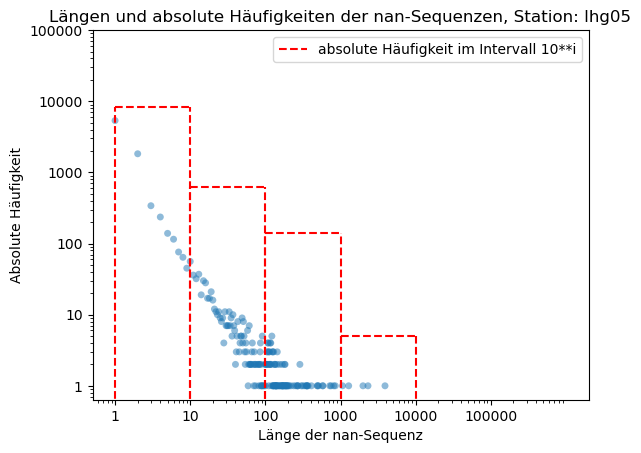

In [33]:
histogramm_scatter(station_touse, column, td)

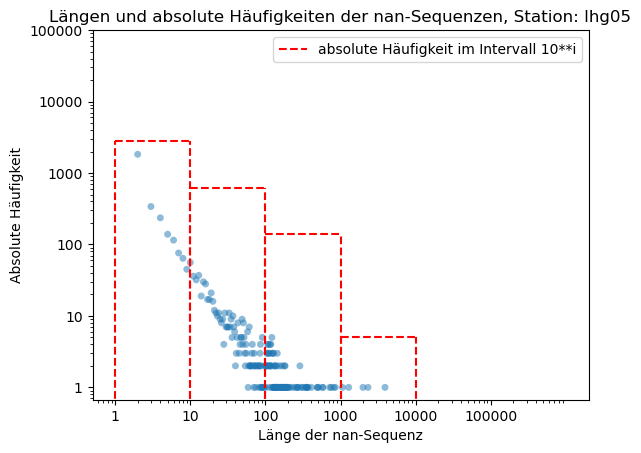

In [34]:
histogramm_scatter(station, column, td)

In [34]:
mask = WS100_rtu['precipitation.1'].isna() & WS100_rtu['precipitation.1'].shift(-1).notnull() & WS100_rtu['precipitation.1'].shift(1).notnull()

In [60]:
mask1 = WS100_rtu['precipitation.1'].isna() & WS100_rtu['precipitation.1'].shift(-1).notnull() & WS100_rtu['precipitation.1'].shift(1).isna() & WS100_rtu['precipitation.1'].shift(2).notnull()
# val nan nan val
mask2 = WS100_rtu['precipitation.1'].isna() & WS100_rtu['precipitation.1'].shift(-1).isna() & WS100_rtu['precipitation.1'].shift(1).notnull() & WS100_rtu['precipitation.1'].shift(-2).notnull()
# val nan nan val

In [45]:
mask1[mask1 == True]

2021-11-05 08:32:00    True
2021-12-29 00:25:00    True
2022-11-21 16:22:00    True
Name: precipitation.1, dtype: bool

In [53]:
mask2[mask2 == True]

2021-11-05 08:31:00    True
2021-12-29 00:24:00    True
2022-11-21 16:21:00    True
Name: precipitation.1, dtype: bool

In [61]:
mask12 = mask1 | mask2

In [57]:
mask12[mask12 == True]

2021-11-05 08:31:00    True
2021-11-05 08:32:00    True
2021-12-29 00:24:00    True
2021-12-29 00:25:00    True
2022-11-21 16:21:00    True
2022-11-21 16:22:00    True
Name: precipitation.1, dtype: bool

In [58]:
WS100_rtu['precipitation.1'][mask12] = 0

In [51]:
mask[mask == True]

Series([], Freq: T, Name: precipitation.1, dtype: bool)

In [62]:
mask12[mask12 == True]

Series([], Freq: T, Name: precipitation.1, dtype: bool)

In [36]:
# nan die alleine Stehen oder nan-Paare zu 0 machen

station_touse = lhg_rtu
column = 'lhg07'
_1seq = True
_2seq = True

station = station_touse[[column]].copy()

# True für alleinstehende nans
mask_1seq = station.isna() & station.shift(-1).notnull() & station.shift(1).notnull()

# True für nan-Paare
mask1 = station.isna() & station.shift(-1).notnull() & station.shift(1).isna() & station.shift(2).notnull()
mask2 = station.isna() & station.shift(-1).isna() & station.shift(1).notnull() & station.shift(-2).notnull()
maske_2seq = mask1 | mask2

if _1seq == True:
    station[mask_1seq] = 0
if _2seq == True:
    station[maske_2seq] = 0

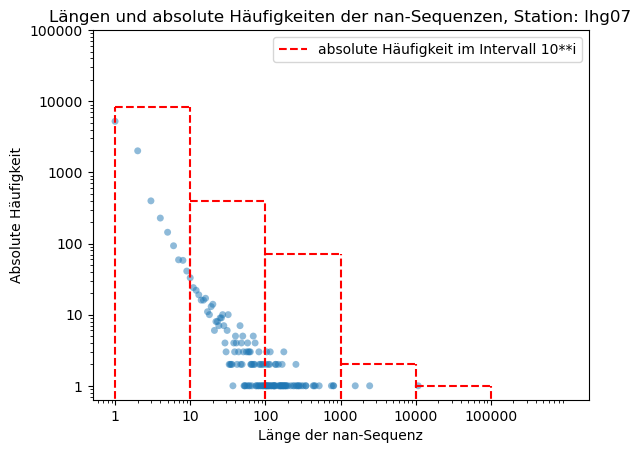

In [37]:
histogramm_scatter(station_touse, column, '5min')

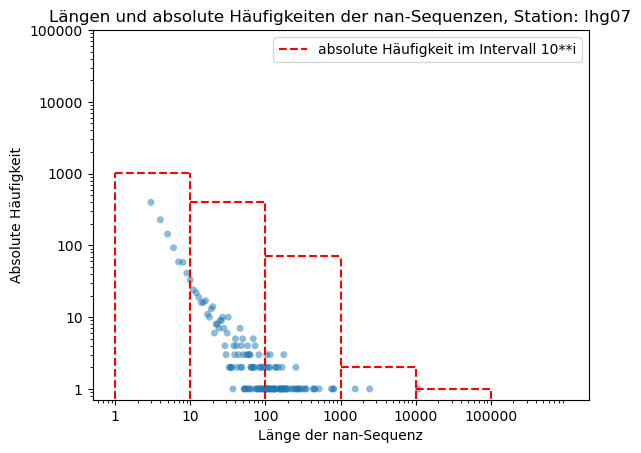

In [38]:
histogramm_scatter(station, column, '5min')

In [39]:
import random

In [43]:
# Erstellen Sie einen DataFrame mit 30 datetime Indizes und einem Abstand von 5 Minuten
df = pd.DataFrame(index=pd.date_range(start='2022-01-01', periods=30, freq='5min'))

# Fügen Sie eine Spalte mit zufälligen Werten hinzu
df['column'] = np.random.rand(30)

# Wählen Sie 3 zufällige Indizes für die NaN-Sequenzen aus
nan_indices = random.sample(range(1, 28), 3)

# Setzen Sie die Werte an diesen Indizes und den folgenden Indizes auf NaN
for index in nan_indices:
    df.iloc[index:index+2] = np.nan

In [70]:
df['column'][-1] = np.nan

In [76]:
# df

In [74]:
# nan die alleine Stehen oder nan-Paare zu 0 machen

station_touse = df
column = 'column'
_1seq = True
_2seq = True

station = station_touse[[column]].copy()

# True für alleinstehende nans
mask_1seq = station.isna() & station.shift(-1).notnull() & station.shift(1).notnull()

# erste und letzte Werte extra betrachten
if (station.iloc[0].isna() & station.iloc[1].notnull()).bool():
    mask_1seq.iloc[0] = True
if (station.iloc[-1].isna() & station.iloc[-2].notnull()).bool():
    mask_1seq.iloc[-1] = True

# True für nan-Paare
mask1 = station.isna() & station.shift(-1).notnull() & station.shift(1).isna() & station.shift(2).notnull()
mask2 = station.isna() & station.shift(-1).isna() & station.shift(1).notnull() & station.shift(-2).notnull()
maske_2seq = mask1 | mask2

# erste zwei und letzte zwei Werte extra betrachten
if (station.iloc[0].isna() & station.iloc[1].isna() & station.iloc[2].notnull()).bool():
    maske_2seq.iloc[0] = True
    maske_2seq.iloc[1] = True
if (station.iloc[-1].isna() & station.iloc[-2].isna() & station.iloc[-3].notnull()).bool():
    maske_2seq.iloc[-1] = True
    maske_2seq.iloc[-2] = True

if _1seq == True:
    station[mask_1seq] = 0
if _2seq == True:
    station[maske_2seq] = 0

In [78]:
def einer_zweier_sequ_korrigieren(data, column, _1seq=True, _2seq=True):
    # nan die alleine Stehen oder nan-Paare zu 0 machen

    station_touse = data

    station = station_touse[[column]].copy()

    # True für alleinstehende nans
    mask_1seq = station.isna() & station.shift(-1).notnull() & station.shift(1).notnull()

    # erste und letzte Werte extra betrachten
    if (station.iloc[0].isna() & station.iloc[1].notnull()).bool():
        mask_1seq.iloc[0] = True
    if (station.iloc[-1].isna() & station.iloc[-2].notnull()).bool():
        mask_1seq.iloc[-1] = True

    # True für nan-Paare
    mask1 = station.isna() & station.shift(-1).notnull() & station.shift(1).isna() & station.shift(2).notnull()
    mask2 = station.isna() & station.shift(-1).isna() & station.shift(1).notnull() & station.shift(-2).notnull()
    maske_2seq = mask1 | mask2

    # erste zwei und letzte zwei Werte extra betrachten
    if (station.iloc[0].isna() & station.iloc[1].isna() & station.iloc[2].notnull()).bool():
        maske_2seq.iloc[0] = True
        maske_2seq.iloc[1] = True
    if (station.iloc[-1].isna() & station.iloc[-2].isna() & station.iloc[-3].notnull()).bool():
        maske_2seq.iloc[-1] = True
        maske_2seq.iloc[-2] = True

    if _1seq == True:
        station[mask_1seq] = 0
    if _2seq == True:
        station[maske_2seq] = 0
    
    return station

In [80]:
lhg05_cor = einer_zweier_sequ_korrigieren(lhg_rtu, 'lhg05')

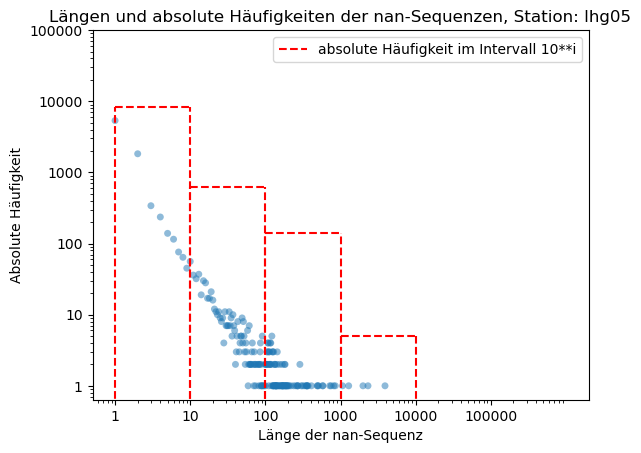

In [82]:
histogramm_scatter(lhg_rtu, 'lhg05', '5min')

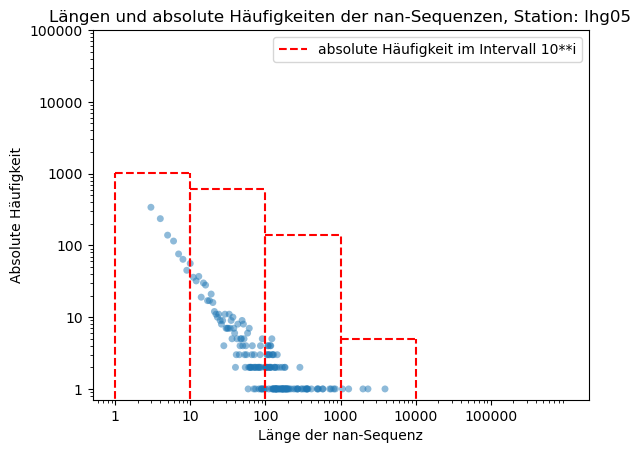

In [81]:
histogramm_scatter(lhg05_cor, 'lhg05', '5min')